#Table of Contents
* [1. Fitting a local equilibrium model to foam scan data](#1.-Fitting-a-local-equilibrium-model-to-foam-scan-data)
	* [1.1 Load data](#1.1-Load-data)
	* [1.2 Experimental data](#1.2-Experimental-data)
	* [1.3 Assign values to the physical parameters](#1.3-Assign-values-to-the-physical-parameters)
	* [1.4 Fit a new liquid relperm](#1.4-Fit-a-new-liquid-relperm)
	* [1.5 Relative permeability curves](#1.5-Relative-permeability-curves)
	* [1.6 Visualize RelPerms](#1.6-Visualize-RelPerms)
	* [1.7 Define the foam model](#1.7-Define-the-foam-model)
* [2. Boeije-Rossen method](#2.-Boeije-Rossen-method)
	* [2.1 Compare the model vs measured saturations](#2.1-Compare-the-model-vs-measured-saturations)
* [3. Ma et al. model](#3.-Ma-et-al.-model)
* [4. Nonlinear least-square model](#4.-Nonlinear-least-square-model)
	* [4.1 Calculate the liquid saturation for data points](#4.1-Calculate-the-liquid-saturation-for-data-points)
	* [4.2 Calculate the experimental foam parameters](#4.2-Calculate-the-experimental-foam-parameters)
	* [4.3 Create and solve a JuMP model: three parameters](#4.3-Create-and-solve-a-JuMP-model:-three-parameters)
	* [4.4 Create and solve a JuMP model: five parameters](#4.4-Create-and-solve-a-JuMP-model:-five-parameters)
	* [4.5 Visualize the results](#4.5-Visualize-the-results)
* [5. A discontinuous model](#5.-A-discontinuous-model)


# 1. Fitting a local equilibrium model to foam scan data

This notebook explains how mathematical programming can be used to optimize the parameters of an implicit function. Here, I will use `Julia` language and the package `JuMP`.

In [1]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim, JLD
@pyimport scipy.optimize as so
PyPlot.rc("font", family="sans")

INFO: Precompiling module JuMP.
INFO: Recompiling stale cache file /home/ehsan/.julia/lib/v0.5/Roots.ji for module Roots.
INFO: Precompiling module Ipopt.
INFO: Recompiling stale cache file /home/ehsan/.julia/lib/v0.5/DataFrames.ji for module DataFrames.
INFO: Recompiling stale cache file /home/ehsan/.julia/lib/v0.5/NLopt.ji for module NLopt.
INFO: Recompiling stale cache file /home/ehsan/.julia/lib/v0.5/Optim.ji for module Optim.
INFO: Recompiling stale cache file /home/ehsan/.julia/lib/v0.5/JLD.ji for module JLD.


LoadError: LoadError: PyError (:PyImport_ImportModule) <type 'exceptions.ImportError'>
ImportError('No module named scipy.optimize',)

while loading In[1], in expression starting on line 427

## 1.1 Load data

First, I read the data table using the `DataFrames` package.

In [3]:
data1 = readtable("AOS0.03_N2_Benth_CT_mu_foam.csv")
deleterows!(data1,7)

,ug,uw,mu_gas,mu_liq,muf_tot,sw_ave,muf_in,fg_in,fg_out,muf_err,dp_tot,dp_mid,dp_err
1,1.011574858307257e-5,4.408724185371063e-6,1.969969273210819e-5,0.0009523524498479937,0.42134945199738294,NaN,0.32888079680003995,0.6919285760342214,0.6919285760342214,0.020369662014730894,4.2841797422680425,1.5736379896907216,0.20711381715740068
2,8.749764881843545e-6,5.878298913828084e-6,1.9674213829660262e-5,0.000952369858221058,0.35589612440405416,0.2632279198686958,0.27511663078658594,0.5937231170267602,0.5937231170267602,0.01508097299674537,3.6444750184522174,1.3257744001652438,0.15443334605743428
3,5.732936812684103e-6,8.817448370742126e-6,1.972314191108221e-5,0.0009523365174535511,0.6842834145585235,0.2586298592947261,0.5865060496251896,0.38587373700633504,0.38587373700633504,0.014350688580324575,6.970041715653897,2.811337108982827,0.14617466377985058
4,7.250684651413146e-6,7.347873642285102e-6,1.968990498847255e-5,0.0009523591252655498,0.543928472318907,0.2559513742837501,0.47342161758895673,0.48974284330359213,0.48974284330359213,0.013798106066224412,5.558743498196948,2.2767953314840503,0.14101143125687912
5,1.3316240151672402e-5,1.4695747284570205e-6,1.963429388719931e-5,0.0009523973403447062,0.17456009835648212,0.2614825222880659,0.1271234133924592,0.8997730730884923,0.8997730730884923,0.016323247710573946,1.8068209422150878,0.6192082712680576,0.1689572020531248
6,1.0270676342226736e-5,4.40872418537106e-6,1.9657260509492045e-5,0.0009523814982529173,0.2838798873587587,0.27643689952669087,0.2219225489679442,0.6965380086081618,0.6965380086081618,0.011198646349780088,2.9172108343558287,1.0731877116564417,0.11507970066372468
7,1.4312964678345894e-6,1.3960959920341696e-5,1.9727015934410857e-5,0.0009523338934055814,0.6930923654625568,0.26678835787737865,0.5933161802793134,0.08995285142576197,0.08995285142576197,0.009432562085573215,7.46824018968386,3.0085305074875204,0.10163816941217159
8,1.178202200872883e-5,2.9391494569140428e-6,1.9646941499430757e-5,0.0009523886056703683,0.21555105354920948,0.27560790818804726,0.16018073103305133,0.7985224114617447,0.7985224114617447,0.009451440879820682,2.221352056949807,0.77681675,0.09740141508858871
9,4.282674001231064e-6,1.0287023099199145e-5,1.973452782632757e-5,0.0009523288117890347,0.8587647754749381,0.25327623568214525,0.7422320346299454,0.28518691933493995,0.28518691933493995,0.016966340999363623,8.758901020212763,3.562510527304965,0.1730468059852794


## 1.2 Experimental data

In [4]:
# Foam quality
ug = float(data1[:ug]) # [m/s]
uw = float(data1[:uw]) # [m/s]
# Viscosity data [Pa.s]
muw = float(data1[:mu_liq])
mug = float(data1[:mu_gas])
u = ug+uw # [m/s]
fg_exp = ug./u # [-]
# Foam apparent viscosity [Pa.s]
muf_exp = float(data1[:muf_tot]) # [Pa.s]
sw_ct= float(data1[:sw_ave])
n_data = length(ug)
# filter the low quality data for the low quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_low= find(fg_exp.<=fg_trans)
fg_low= fg_exp[ind_fg_low]
sw_low= sw_ct[ind_fg_low]
muf_low= muf_exp[ind_fg_low]
muw_low= muw[ind_fg_low]
# filter the high quality data for the high quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_high= find(fg_exp.>=fg_trans)
fg_high= fg_exp[ind_fg_high]
sw_high= sw_ct[ind_fg_high]
muf_high= muf_exp[ind_fg_high]
println("Data is loaded.")

Data is loaded.


## 1.3 Assign values to the physical parameters

In [5]:
# IFT value [N/m]
sigma_wg = 0.03;

## 1.4 Fit a new liquid relperm

Here, I fit a new liquid relperm to the low quality data points.

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in @defVar(::Symbol, ::Vararg{Any,N}) at /home/ali/.julia/v0.5/JuMP/src/deprecated.jl:24
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ali/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/ali/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[6], in expression starting on line 11


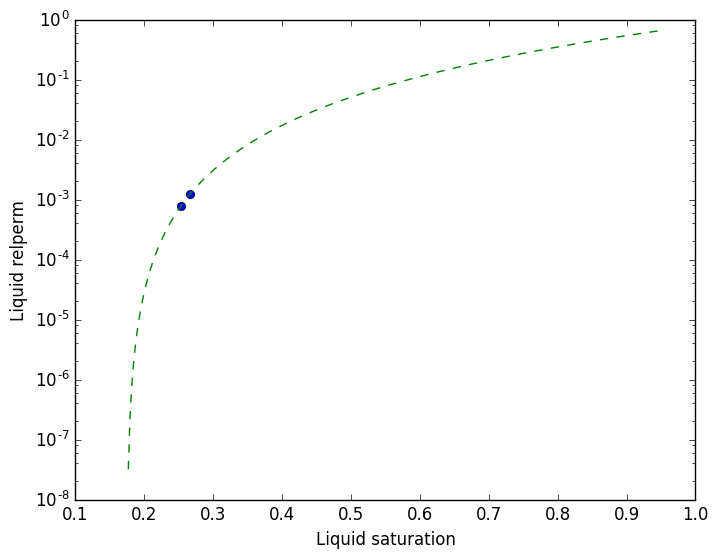


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in getValue(::JuMP.Variable, ::Vararg{JuMP.Variable,N}) at ./deprecated.jl:30
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ali/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/ali/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[6], in expression starting on line 19


4-element Array{Float64,1}:
 0.646221 
 2.94855  
 0.174138 
 0.0539599

In [6]:
# I only use the less-scattered data in the low quality region
#filter for measured saturation
ind1= ~isnan(sw_low)
krw_exp= (1.0-fg_low[ind1]).*muw_low[ind1]./muf_low[ind1]
sw_low_ct=sw_low[ind1]
n_low=length(sw_low_ct)
semilogy(sw_low_ct, krw_exp, "o")
m1 = Model(solver=IpoptSolver(print_level=1))
#m = Model()
# define the variables of the foam model
@defVar(m1, 0.05<=nw_fit<=6.0)
@defVar(m1, 0.05<=krw0_fit<=1.0)
@defVar(m1, 0.001<=swc_fit<=0.2)
@defVar(m1, 0.001<=sgr_fit<=0.1)
@setNLObjective(m1, Min, sum{(log(krw_exp[i])-log(krw0_fit)-nw_fit*log((sw_low_ct[i]-swc_fit)/(1.0-swc_fit-sgr_fit)))^2, i=1:n_low})
#@setNLObjective(m1, Min, sum{(krw_exp[i]-krw0_fit*((sw_low_ct[i]-swc_fit)/(1.0-swc_fit-sgr_fit))^nw_fit)^2, i=1:n_low})
solve(m1)
# get the result
liq_relperm=[getValue(krw0_fit), getValue(nw_fit), getValue(swc_fit), getValue(sgr_fit)]
sw1=[linspace(liq_relperm[3], 0.3, 50); linspace(0.3,1.0-liq_relperm[4], 50)]
semilogy(sw1, liq_relperm[1]*((sw1-liq_relperm[3])/(1-liq_relperm[4]-liq_relperm[3])).^liq_relperm[2], "--")
xlabel("Liquid saturation")
ylabel("Liquid relperm")
#df_krw=DataFrame(sw=sw_low_ct, krw=krw_exp)
#writetable("krw_low_AOS.csv", df_krw)
liq_relperm

## 1.5 Relative permeability curves

In [11]:
# Relperm data
# swc = 0.207
swc=0.07
sgr = 0.03
krg0 = 0.587
ng = 0.938
krw0 = 0.713 
nw = 2.460 
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0))

krw (generic function with 1 method)

In [8]:
mean(mug)

1.9687443679798193e-5

## 1.6 Visualize RelPerms

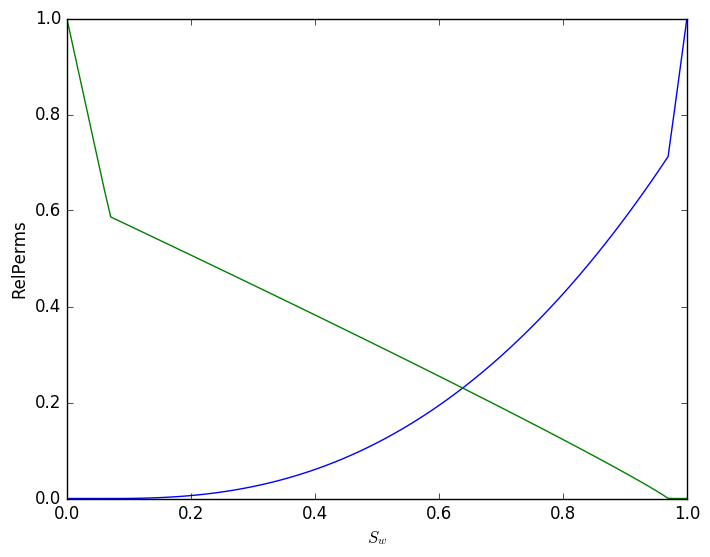

PyObject <matplotlib.text.Text object at 0x7f8ffad43250>

In [12]:
sw_plot = collect(linspace(0.0,1.0, 100))
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
xlabel(L"S_w")
ylabel("RelPerms")

## 1.7 Define the foam model

In [13]:
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2)=(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 1 method)

## 4.1 Calculate the liquid saturation for data points

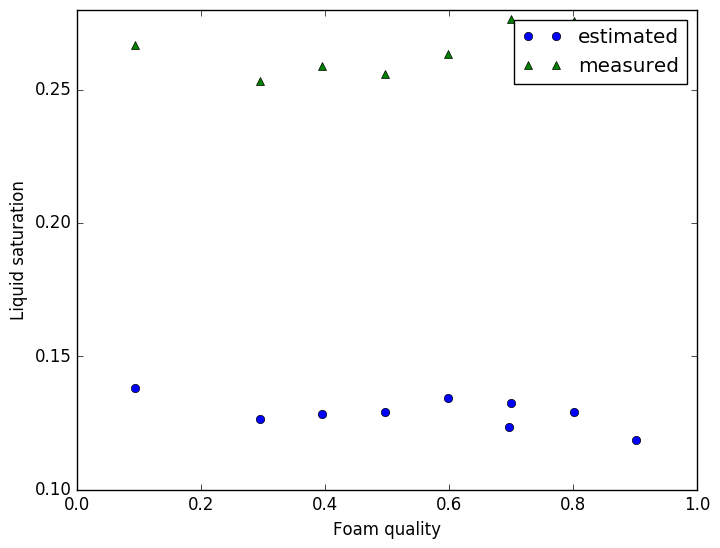

In [14]:
sw_exp = (1-swc-sgr)*(muw.*(1-fg_exp)./(krw0*muf_exp)).^(1/nw)+swc
labdaw = krw(sw_exp)./muw
labdag = kr(sw_exp)./mug
plot(fg_exp, sw_exp, "o")
plot(fg_exp, sw_ct, "^")
xlabel("Foam quality")
ylabel("Liquid saturation")
legend(["estimated", "measured"]);

# 2. Boeije-Rossen method

I'm trying to automate the Boeije-Rossen method, using linear regression for the high quality and power-law for the low quality region.

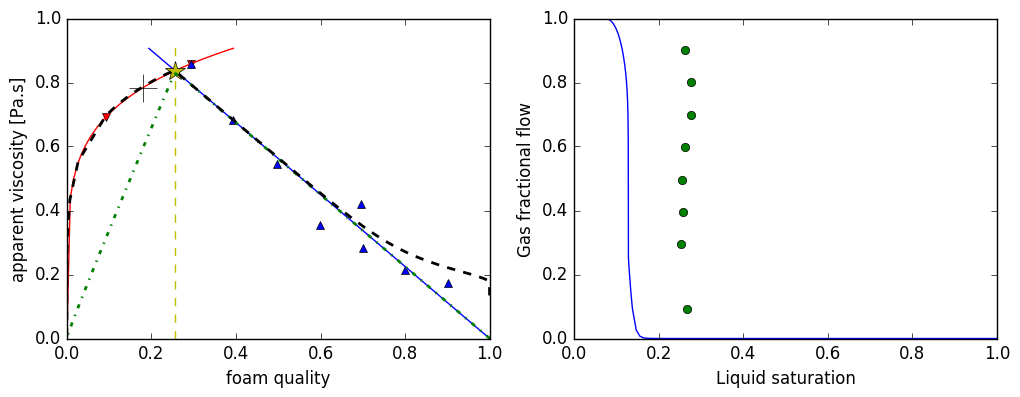

5-element Array{Float64,1}:
      8.61768e7 
 100000.0       
      0.12822   
      8.60338e-5
      4.36984   

In [19]:
# fit a line to the high quality data; note: y=a+b*x
w1=ones(length(fg_high)+1) # weight factor
a_high=zeros(2)
a_high[1], a_high[2]=linreg([fg_high;1.0], [muf_high;0.0])
a_high[1]=-a_high[2] # force it to go through point [1,0]
# fit a power law to the low quality data
# y=a*x^b; log(y)=log(a)+b*log(x)
w2=ones(length(fg_low)) # weight factor
#w2[end-1:end]=1.0 # a larger weight to the points near the transition
a_low=linreg(log(fg_low),log(muf_low))
fg_low_range=linspace(0.0, maximum(fg_low)+0.1, 50)
fg_high_range=linspace(maximum(fg_low)-0.1,1.0, 10)
figure(figsize=[12,4])
subplot(1,2,1)
plot(fg_low, muf_low, "vr", fg_low_range, exp(a_low[1])*fg_low_range.^a_low[2], "r-")
plot(fg_high, muf_high, "b^", fg_high_range, a_high[1]+a_high[2]*fg_high_range, "b-")
# find the transition quality
fun1(x)=exp(a_low[1])*x^a_low[2]-(a_high[1]+a_high[2]*x)
fg_trans = fzero(fun1, maximum(fg_low))
muf_trans = a_high[1]+a_high[2]*fg_trans
plot(fg_trans, muf_trans, "*y", markersize=15, [fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(muw[ind_mu_max].*(1-fg_trans)./(krw0*muf_trans)).^(1/nw)+swc
fmdry_br= sw_trans
# find fmmob
FM_trans = mug[ind_mu_max]/muw[ind_mu_max]*fg_trans/(1-fg_trans)*(krw(sw_trans)/kr(sw_trans))
fmmob_br= 1.0/FM_trans-1.0
# find epdry
epdry_br= 100000.0 # very convenient
# visualize the three-parameter fit
x_br=[fmmob_br, epdry_br, fmdry_br]
sw_val = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
fg_opt = fg(sw_val, x_br)
muf_opt = mu_foam(sw_val, x_br)
plot(fg_opt, muf_opt, "-.g", linewidth=2)
# calculate the epcap
dryout(x, sw)=0.5+atan(x[1]*(sw-x[2]))/π
fg_plus=0.7*fg_trans
muf_plus= exp(a_low[1])*fg_plus^a_low[2]
plot(fg_plus, muf_plus, "k+", markersize=20)
sw_plus=(1-swc-sgr)*(muw[ind_mu_max].*(1-fg_plus)./(krw0*muf_plus)).^(1/nw)+swc
#FM_plus = mug[ind_mu_max]/muw[ind_mu_max]*fg_plus/(1-fg_plus)*(krw(sw_plus)/kr(sw_plus))
#epcap_br=log((1.0/FM_trans-1.0)/(1.0/FM_plus-1.0)*
#dryout([epdry_br,fmdry_br],sw_plus)/dryout([epdry_br,fmdry_br],sw_trans))/log(muf_plus/muf_trans)
epcap_br=log((kr(sw_trans)*muf_plus-fg_plus*mug[ind_mu_max])/
(fmmob_br*mug[ind_mu_max]*fg_plus))/log(muf_trans/muf_plus)
# calculate fmcap
ind_muf_min = indmin(muf_exp)
fmcap_br= muf_exp[ind_muf_min]*u[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans/muf_exp[ind_muf_min])^epcap_br
# visualize the final results
x_br2= [fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]
sw_p = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n1 = length(sw_p)
muf_opt = zeros(n1)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n1
    fmu(x)= x-mu_foam2(sw_p[i], x_br2[1:3], x_br2[4:5], x, u_ave)
    muf_opt[i]=fzero(fmu, 0.9)
end
plot(fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), mu_foam2(sw_p, x_br2[1:3], 
x_br2[4:5], muf_opt, u_ave), "k--", linewidth=2)
#legend(["LQ", "Power-law", "HQ", "Linear", L"\mu_f^*", L"f_g^*", "3-par-fit", L"f_g^+", "5-par-fit"])
subplot(1,2,2)
plot(sw_p, fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
fit_br=[fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]

# 3. Ma et al. model

The optimization procedure of Ma et al. can be impplemented as follows:

# 4. Nonlinear least-square model

## 4.2 Calculate the experimental foam parameters

See our paper for more details.

In [12]:
#FM = mug./muw.*fg_exp./(1-fg_exp).*(krw(sw_exp)./kr(sw_exp))
FM = mug.*fg_exp./(kr(sw_exp).*muf_exp)
f_foam = 1.0./FM-1.0;

## 4.3 Create and solve a JuMP model: three parameters

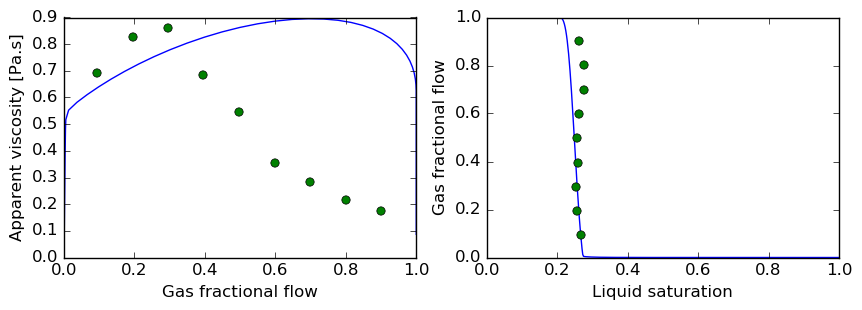

3-element Array{Float64,1}:
   3.4568e6
 913.534   
   0.273171

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/ali/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/ali/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[13], in expression starting on line 20


In [13]:
#m1 = Model(solver=IpoptSolver(print_level=1))
m1 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
#m = Model()
# define the variables of the foam model
@defVar(m1, 10<=fmmob<=5000000)
@defVar(m1, 10<=epdry<=5000)
@defVar(m1, swc<=fmdry<=swc+0.4, start=minimum(sw_exp))
w=ones(length(muf_exp))
ind_mu_max= indmax(muf_exp)
w[ind_mu_max-2:ind_mu_max+1]=10
#@setNLObjective(m1, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
#@setNLObjective(m1, Min, sum{w[i]*(f_foam[i]-(fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
#@setNLObjective(m1, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi))))^2, i=1:n_data})
@setNLObjective(m1, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
solve(m1)
# get the result
x1 = [getValue(fmmob), getValue(epdry), getValue(fmdry)]
sw_val = [linspace(0,1.0, 500)]
fg_opt = fg(sw_val, x1)
muf_opt = mu_foam(sw_val, x1)
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg_opt, muf_opt, fg_exp, muf_exp, "o")
xlabel("Gas fractional flow")
ylabel("Apparent viscosity [Pa.s]")
subplot(1,2,2)
plot(sw_val, fg_opt, sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
x1

In [14]:
muf_exp[ind_mu_max]

0.8587647755

## 4.4 Create and solve a JuMP model: five parameters

Here's a list of NLopt algorithms (note: "NLOPT_{G,L}{N,D}_xxxx, where G/L denotes global/local optimization and N/D denotes derivative-free/gradient-based algorithms, respectively"  
  - GN_DIRECT_L
  - GN_DIRECT
  - GN_DIRECT_L_RAND
  - GN_DIRECT_NOSCAL
  - GN_DIRECT_L_NOSCAL
  - GN_DIRECT_L_RAND_NOSCAL
  - GN_ORIG_DIRECT_L
  - GN_CRS2_LM
  - G_MLSL_LDS
  - GN_MLSL
  - GD_STOGO
  - GD_STOGO_RAND
  - GN_ISRES
  - GN_ESCH
  - LN_COBYLA
  - LN_BOBYQA
  - LN_NEWUOA_BOUND
  - LN_NEWUOA
  - LN_PRAXIS
  - LN_NELDERMEAD
  - LN_SBPLX
  - LD_MMA
  - LD_CCSAQ
  - LD_SLSQP
  - LD_LBFGS
  - LD_TNEWTON_PRECOND
  - LD_TNEWTON_PRECOND_RESTART
  - LD_TNEWTON
  - LD_TNEWTON_RESTART
  - LD_VAR2
  - LD_VAR1

In [15]:
#m2 = Model(solver=IpoptSolver(print_level=1))
m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m2, 10<=fmmob<=5000000)
@defVar(m2, 10<=epdry<=100000)
@defVar(m2, swc<=fmdry<=sw_exp[ind_mu_max])
@defVar(m2, 1e-7<=fmcap<=1e-4)
@defVar(m2, 0.0<=epcap<=4.0)
w=ones(length(muf_exp))
w[[ind_mu_max-2:ind_mu_max]]=5000
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(1.0-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)/f_foam[i]
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, :Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(1.0-(1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/muf_exp[i])^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
     2.46914e6 
 22230.0       
     0.254747  
     8.39667e-5
     1.97531   

In [16]:
#fit_br
ind_mu_max

3

## 4.5 Visualize the results

One method is to calculate the pressure drop in different gas and liquid rates, and plot the pressure drop contours versus gas and liquid velocity. The following result is visualized for a few average total flow rates.

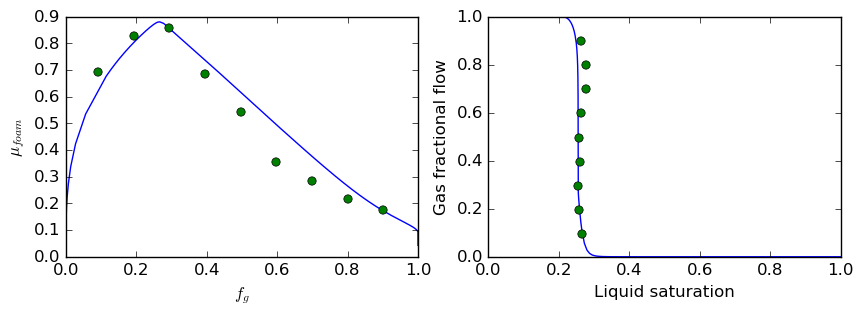

In [17]:
sw_plot = [linspace(eps(), minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_upper=so.fminbound(fmu, 0.0, 5.0)
    mu_lower=so.fminbound(fmu2, 0.0, 5.0)
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
end
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");

In [26]:
fg_opt=fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave)
muf_opt=mu_foam2(sw_plot, x2[1:3],x2[4:5], muf_opt, u_ave)
save("low_AOS.jld", "fg", fg_opt, "muf", muf_opt, 
"sw", sw_plot, "sw_exp", sw_ct, 
"fg_exp", fg_exp, "muf_exp", muf_exp, "u", u, "cmg_stars", x2)

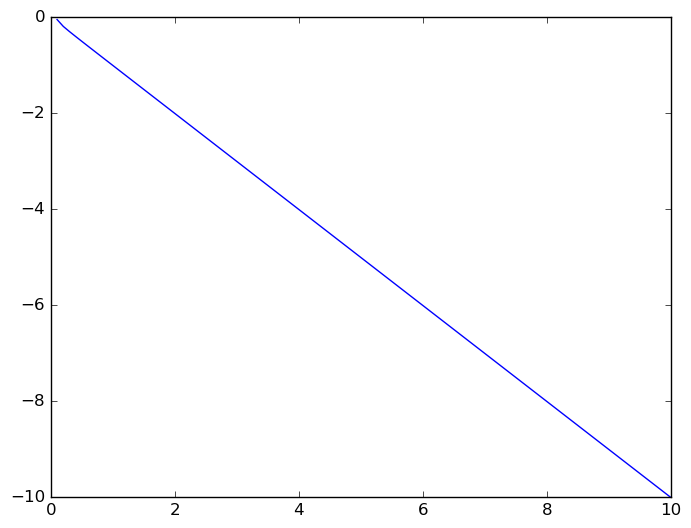

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f458980d4d0>

In [19]:
mu1=linspace(0,10,100)
fmu(x)= (mu_foam2(0.19821182940792934, x2[1:3], x2[4:5], x, u_ave)-x)
fmu1=zeros(length(mu1))
for i=1:length(mu1)
    fmu1[i]=fmu(mu1[i])
end
plot(mu1,fmu1)

## Using Optim package

In [20]:
w[ind_mu_max-2:ind_mu_max+1]=100
f_obj(x)= sum(w.*(FM-1.0./(1.0+x[1]*(0.5+atan(x[2]*(sw_exp-x[3]))/pi).*(x[4]./(u.*muf_exp/sigma_wg)).^x[5])).^2)
x_low=[10.0, 10.0, swc, 1e-7, -3.0]
x_high=[5.0e6, 1.0e6, 0.4, 1.0e-4, 4.0]
d4 = DifferentiableFunction(f_obj)
opt_out=fminbox(d4, [1.0e5, 1.0e2, swc+0.02, 1e-5, 1.0], x_low, x_high)
x2=opt_out.minimum
sw_plot = [linspace(eps(), minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    mu_upper=so.fminbound(fmu, 0.0, 5.0)
    muf_opt[i]=fzero(fmu, [0.0,mu_upper])
end
subplot(2,1,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(2,1,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_ct, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");
x2

LoadError: LoadError: DomainError:
while loading In[20], in expression starting on line 6

# 5. A discontinuous model

Note: $f_g$ --> 0, $\mu_{app}$ --> $\mu_{app,0}$  
The first step is to fit a curve (line, polynomial, or power law) to the low quality regime and find the $\mu_{app,0}$. Then, the new functions that are defined below will be used to fit the foam scan data.

In [21]:
# define the new model with mu_app0
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2, mu0)=mu0+(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u, mu0)=mu0+(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 2 methods)

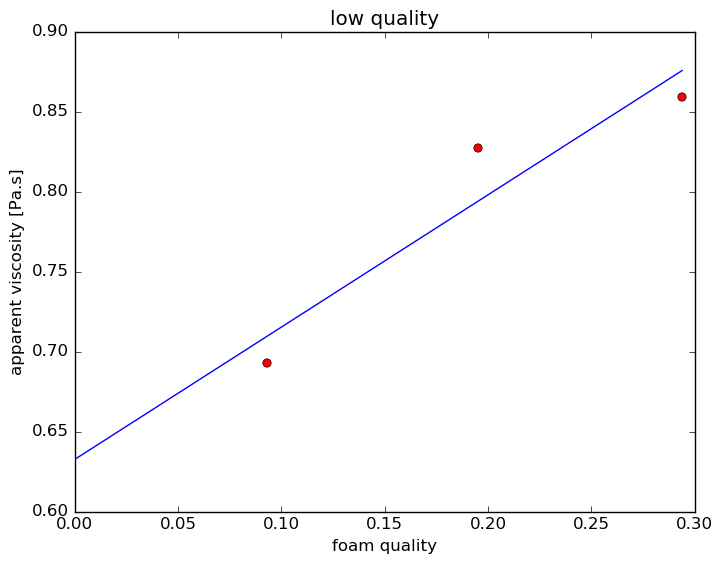

PyObject <matplotlib.text.Text object at 0x7f4589945650>

In [22]:
(muf_0,dmudfg)=linreg(fg_low, muf_low)
fg_low_range=linspace(0.0, maximum(fg_low), 20)
plot(fg_low, muf_low, "or", fg_low_range, dmudfg*fg_low_range+muf_0)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("low quality")

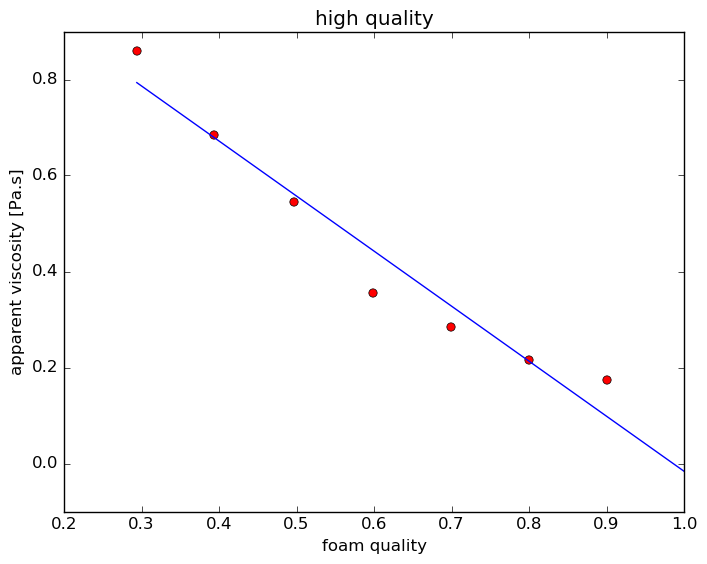

-0.016122417115600474

In [23]:
(muf_end,dmudfg)=linreg(fg_high, muf_high)
fg_high_range=linspace(minimum(fg_high), 1.0, 20)
plot(fg_high, muf_high, "or", fg_high_range, dmudfg*fg_high_range+muf_end)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
title("high quality")
[dmudfg*fg_high_range+muf_end][end]

A negative value is obtained. The fit is not really a fit. I would say at fg=0, we can go with the gas viscosity.

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/ali/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/ali/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[23], in expression starting on line 7


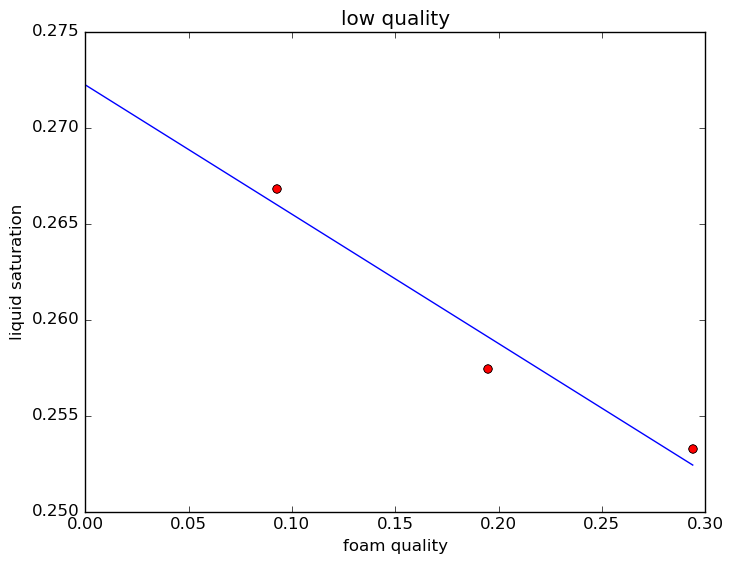

0.2722215651089655

In [24]:
plot(fg_low, sw_low, "or")
(sw_0,dswdfg)=linreg(fg_low, sw_low)
plot(fg_low, sw_low, "or", fg_low_range, dswdfg*fg_low_range+sw_0)
xlabel("foam quality")
ylabel("liquid saturation")
title("low quality")
sw_0

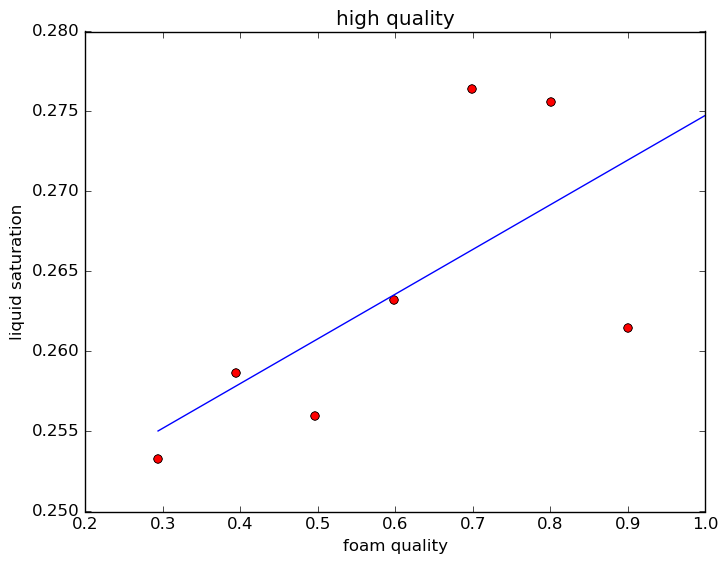

0.2747553403463785

In [25]:
plot(fg_high, sw_high, "or")
(sw_end,dswdfg)=linreg(fg_high, sw_high)
plot(fg_high, sw_high, "or", fg_high_range, dswdfg*fg_high_range+sw_end)
xlabel("foam quality")
ylabel("liquid saturation")
title("high quality")
[dswdfg*fg_high_range+sw_end][end]